Initializing Ollama LLM: gemma3:12b
Initializing Ollama Embedding: nomic-embed-text
Ollama Base URL: http://localhost:11434
LlamaIndex Settings configured: LLM=gemma3:12b, Embeddings=nomic-embed-text, ChunkSize=512
Loading existing vector index from: pdf_index_local
Vector index loaded successfully.

Building LangGraph workflow...
Workflow compiled successfully.
Generating graph visualization...


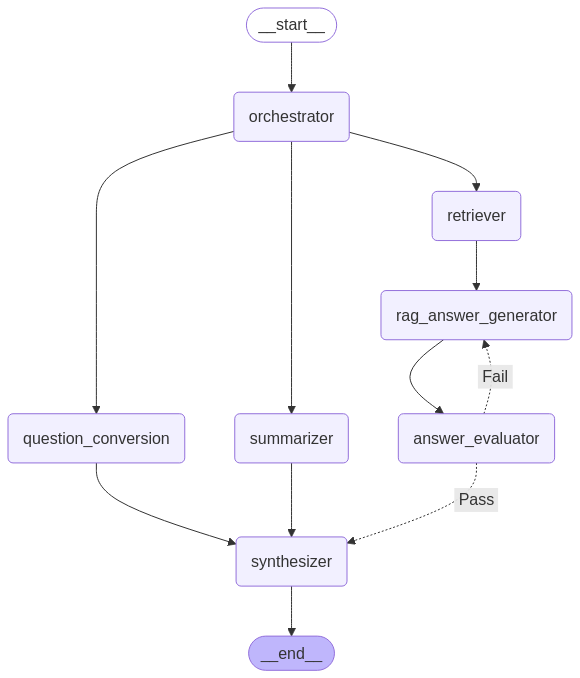

Graph visualization displayed.

--- Starting RAG Workflow Execution (PDF Source) ---

========== Answering Question ==========
Invoking workflow...

========== Workflow Start ==========
[Orchestrator] Received question: 'What is the main topic discussed in the document?'
[Question Conversion] Starting...
[Retriever] Starting...
[Question Summary] Starting...
[Retriever] Found 3 relevant contexts for query: 'What is the main topic discussed in the document?'
[Question Conversion] Converted question: 'What does the document primarily focus on?'
[Question Summary] Summary: 'The question asks for the central subject or theme explored within the document.'
[RAG Answer Generator] Starting...
[Synthesizer] Starting...
[Synthesizer] Evaluation passed: False, Attempts: 0
[Synthesizer] Processing history: ['orchestrator', 'question_conversion', 'retriever', 'summarizer']
[Synthesizer] Final Answer:
Please provide the "Detailed Answer" you are referring to. I need that text to synthesize a final 

In [4]:
# This notebook implements a Retrieval-Augmented Generation (RAG) system
# using LangGraph and LlamaIndex with a local Gemma3 model via Ollama.
# It now ingests data from PDF files in a specified directory.
# The workflow orchestrates multiple parallel processes to create
# high-quality, context-aware responses to user questions based on the PDF content.

## Workflow Architecture
# 1. **Orchestrator**: Initiates the workflow and distributes the query to parallel processes
# 2. **Question Processing**: Runs in parallel:
#    - **Question Conversion**: Reformulates the original question
#    - **Question Summary**: Creates a concise summary of the core request
#    - **Retrieval**: Finds relevant documents from a vector database
# 3. **RAG Generation**: Creates answers based on retrieved information
# 4. **Quality Evaluation**: Rates answer quality and loops back if necessary
# 5. **Synthesis**: Combines all components into a final cohesive response

## Key Components
# - **Vector Store**: Stores document embeddings for semantic search (using local embeddings)
# - **LLM Integration**: Uses a local Gemma model via Ollama for generation tasks
# - **Parallel Processing**: Efficiently processes multiple steps concurrently
# - **Quality Control**: Implements evaluation-based feedback loop
# - **Graceful Fallbacks**: Handles errors at each step with sensible defaults

## Usage
# This implementation demonstrates a complete LangGraph workflow for question answering with:
# - Fan-out parallel processing
# - Conditional routing
# - State management with annotations
# - Document retrieval and context integration
# Simply run answer_question("Your question here") via main to process a query through the entire workflow.


# --- Prerequisites ---
# 1. Install Ollama: https://ollama.com/
# 2. Pull the required models (Update model names in CONFIG section if needed):
#    ollama pull gemma:latest  # Or your specific Gemma model
#    ollama pull nomic-embed-text # Or another embedding model
# 3. Install Python libraries:
#    pip install llama-index langgraph llama-index-llms-ollama llama-index-embeddings-ollama ipython pypdf
#    # Optional for graph visualization:
#    # pip install pygraphviz
# 4. **Create Data Directory**: Create a folder (e.g., "data") in the same directory as this script.
# 5. **Add PDF**: Place your PDF file(s) inside the "data" folder.
# ---------------------

import os
from typing_extensions import TypedDict, Annotated
from typing import List
import operator
import re
from IPython.display import Image, display

from langgraph.graph import StateGraph, START, END
# --- LlamaIndex Imports ---
from llama_index.llms.ollama import Ollama
from llama_index.embeddings.ollama import OllamaEmbedding
from llama_index.core.llms import ChatMessage, MessageRole
from llama_index.core import (
    VectorStoreIndex,
    Document,
    StorageContext,
    load_index_from_storage,
    Settings, # Use Settings for global configuration
    SimpleDirectoryReader # Added for loading data from files (PDFs)
)
from llama_index.core.node_parser import SentenceSplitter

# Define state with proper annotated types for parallel execution
class WorkflowState(TypedDict):
    # Original question from user (read-only input)
    original_question: str
    # For parallel processes
    converted_question: str
    question_summary: str
    # For RAG process
    retrieved_contexts: List[str] # Documents retrieved from the vector store
    rag_answer: str
    evaluation_passed: bool
    attempt_count: int
    # Final output
    final_answer: str
    # We use a list with the operator.add reducer to track processing
    processed: Annotated[List[str], operator.add]

# --- Configuration ---
# !! IMPORTANT: Update these values based on your Ollama setup and data location !!
LOCAL_LLM_MODEL = "gemma3:12b" # Replace with your specific Gemma model ID in Ollama, or any other oolama model
LOCAL_EMBEDDING_MODEL = "nomic-embed-text" # Recommended embedding model for Ollama
OLLAMA_BASE_URL = "http://localhost:11434" # Default Ollama URL
REQUEST_TIMEOUT = 120.0 # Timeout in seconds
# --- Configuration for Data Ingestion ---
DATA_DIRECTORY = "data" # Directory containing your PDF file(s), create that where you run the script
VECTOR_INDEX_PATH = "pdf_index_local" # Persistence path for the index built from PDFs

# Set up Local LLM and Embedding Model via Ollama
def initialize_llm_and_embed():
    """Initialize the Ollama LLM and Embedding clients."""
    print(f"Initializing Ollama LLM: {LOCAL_LLM_MODEL}")
    print(f"Initializing Ollama Embedding: {LOCAL_EMBEDDING_MODEL}")
    print(f"Ollama Base URL: {OLLAMA_BASE_URL}")

    llm = Ollama(
        model=LOCAL_LLM_MODEL,
        base_url=OLLAMA_BASE_URL,
        request_timeout=REQUEST_TIMEOUT,
        temperature=0.0, # Keep deterministic for consistency
    )

    embed_model = OllamaEmbedding(
        model_name=LOCAL_EMBEDDING_MODEL,
        base_url=OLLAMA_BASE_URL,
    )

    # --- Configure LlamaIndex Settings ---
    # Set models globally for LlamaIndex operations
    Settings.llm = llm
    Settings.embed_model = embed_model
    # You might need to adjust chunk size/overlap based on the embedding model and PDF content
    Settings.chunk_size = 512
    Settings.chunk_overlap = 20
    print(f"LlamaIndex Settings configured: LLM={Settings.llm.model}, Embeddings={Settings.embed_model.model_name}, ChunkSize={Settings.chunk_size}")

    return llm, embed_model

# Initialize LLM client and embedding model
llm, embed_model = initialize_llm_and_embed()

# Set up RAG components using PDF data
def initialize_vector_store():
    """ Initialize or load the vector store for RAG from PDF documents.
        If a persisted index exists, load it. Otherwise, create a new one
        by reading PDFs from the DATA_DIRECTORY using the configured
        local embedding model.
    """
    index_path = VECTOR_INDEX_PATH
    data_dir = DATA_DIRECTORY

    try:
        # Try to load existing index
        if os.path.exists(index_path):
            print(f"Loading existing vector index from: {index_path}")
            storage_context = StorageContext.from_defaults(persist_dir=index_path)
            # No need to pass embed_model here if Settings are configured
            index = load_index_from_storage(storage_context)
            print("Vector index loaded successfully.")
            return index
        else:
            print(f"No existing index found at {index_path}.")
            # --- Load data from PDF(s) ---
            print(f"Creating new vector index from documents in: {data_dir}")

            # Check if data directory exists
            if not os.path.isdir(data_dir):
                 print(f"Error: Data directory '{data_dir}' not found.")
                 print("Please create the directory and place your PDF file(s) inside.")
                 return None

            print(f"Loading documents from '{data_dir}'...")
            # SimpleDirectoryReader will automatically find and parse PDFs (requires pypdf)
            # It can also handle other file types if present.
            reader = SimpleDirectoryReader(input_dir=data_dir)
            documents = reader.load_data(show_progress=True)

            if not documents:
                print(f"Error: No documents were loaded from '{data_dir}'. Ensure PDF files are present and readable.")
                return None

            print(f"Successfully loaded {len(documents)} document(s).")
            print(f"Using embedding model: {Settings.embed_model.model_name}")

            # Node parser uses Settings.chunk_size, Settings.chunk_overlap
            parser = SentenceSplitter()
            nodes = parser.get_nodes_from_documents(documents, show_progress=True)
            print(f"Parsed {len(documents)} documents into {len(nodes)} nodes.")

            if not nodes:
                 print("Error: Failed to parse any nodes from the documents.")
                 return None

            # Create vector store index using the globally set embed_model
            print("Creating vector store index...")
            index = VectorStoreIndex(nodes, show_progress=True)
            print("Vector index created successfully.")

            # Persist index
            print(f"Persisting vector index to: {index_path}")
            os.makedirs(index_path, exist_ok=True) # Ensure directory exists
            index.storage_context.persist(persist_dir=index_path)
            print(f"Vector index persisted successfully.")
            return index
    except ImportError:
         print("Error: 'pypdf' library not found. Please install it using: pip install pypdf")
         return None
    except Exception as e:
        print(f"Error initializing vector store: {e}")
        # Return None if failed, will use fallback in retrieval function
        return None

# Initialize the vector index from PDFs
vector_index = initialize_vector_store()


def call_llm(prompt: str, system_prompt: str = "You are a helpful assistant that provides clear, concise responses.") -> str:
    """ Call the local LLM with the given prompt using the .chat interface. """
    try:
        messages = [
            ChatMessage(role=MessageRole.SYSTEM, content=system_prompt),
            ChatMessage(role=MessageRole.USER, content=prompt)
        ]
        # Use the globally configured llm from Settings
        response = Settings.llm.chat(messages)
        return response.message.content
    except Exception as e:
        print(f"Error calling local LLM ({Settings.llm.model}): {e}")
        # Fallback responses
        # These might not be triggered if Ollama itself handles errors differently
        # Fallback Logic to English
        if "Convert the following question" in prompt: # Check for English prompt text
             return "How do you make a soft and moist chocolate cake? (Fallback)" # English fallback
        elif "Summarize this question" in prompt: # Check for English prompt text
             return "Recipe for a moist chocolate cake (Fallback)" # English fallback
        elif "Based on available knowledge" in prompt: # Kept original check, assuming it was meant to be generic
             return "To bake a perfect chocolate cake you need: [Fallback Ingredients]"
        elif "Evaluate the following answer" in prompt: # Updated check for evaluator prompt
             return "5" # Fallback evaluation score
        else:
             return f"[ERROR] Failed to get response from local LLM: {e}"


# --- retrieve_relevant_contexts function ---
def retrieve_relevant_contexts(query: str, top_k: int = 3) -> List[str]:
    """ Retrieve relevant contexts from the vector store based on query """
    try:
        if vector_index is None:
            print("Vector index not available. Using fallback.")
            # Fallback if vector store initialization failed
            return ["No vector index available. Using general knowledge."]

        # Retriever uses the globally configured embed_model from Settings
        retriever = vector_index.as_retriever(similarity_top_k=top_k)
        retrieval_results = retriever.retrieve(query)

        # Extract text from nodes
        contexts = [node.node.text for node in retrieval_results]

        # Print retrieved contexts for debugging
        print(f"[Retriever] Found {len(contexts)} relevant contexts for query: '{query}'")
        # for i, ctx in enumerate(contexts):
        #     print(f"Context {i+1} (excerpt): {ctx[:100]}...") # Keep console tidy
        return contexts
    except Exception as e:
        print(f"Error during retrieval: {e}")
        return ["Error retrieving information. Using general knowledge instead."]

# --- LangGraph Nodes ---

def orchestrator(state: WorkflowState) -> dict:
    """Initial orchestrator that receives the user question"""
    question = state["original_question"]
    print(f"\n{'='*10} Workflow Start {'='*10}")
    print(f"[Orchestrator] Received question: '{question}'")
    # Return the processed marker
    return {
        "attempt_count": 0,
        "processed": ["orchestrator"]
    }

def question_conversion(state: WorkflowState) -> dict:
    """Converts the question to another form (Using English Prompt)"""
    question = state["original_question"]
    print("[Question Conversion] Starting...")
    prompt = (
        f"Convert the following question to another form: {question}\n"
        "Keep it concise and precise."
    )
    converted = call_llm(prompt)
    print(f"[Question Conversion] Converted question: '{converted}'")
    return {
        "converted_question": converted,
        "processed": ["question_conversion"]
    }

def question_summary(state: WorkflowState) -> dict:
    """Summarizes the question in one sentence (Using English Prompt)"""
    question = state["original_question"]
    print("[Question Summary] Starting...")
    # --- UPDATED Prompt to English ---
    prompt = (
        f"Summarize this question in one sentence: {question}\n"
        "Focus on the core message."
    )
    summary = call_llm(prompt)
    print(f"[Question Summary] Summary: '{summary}'")
    return {
        "question_summary": summary,
        "processed": ["summarizer"]
    }

def retrieval_step(state: WorkflowState) -> dict:
    """Retrieve relevant contexts for the question from the PDF index"""
    question = state["original_question"]
    print("[Retriever] Starting...")
    # Retrieve contexts from vector store (built from PDF)
    contexts = retrieve_relevant_contexts(question)
    return {
        "retrieved_contexts": contexts,
        "processed": ["retriever"]
    }

def rag_answer_generator(state: WorkflowState) -> dict:
    """Generates an answer using RAG approach with retrieved contexts (from PDF)"""
    print("[RAG Answer Generator] Starting...")
    question = state["original_question"]
    contexts = state.get("retrieved_contexts", [])
    attempt_count = state.get("attempt_count", 0) # Get attempt count for context

    # System prompt for RAG (emphasize using ONLY provided context)
    rag_system_prompt = "You are a helpful assistant that provides clear, concise answers based ONLY on the provided context information retrieved from documents. If the context doesn't contain the answer, clearly state that the provided documents do not contain the necessary information."

    # Create chat template for RAG
    chat_messages = [
        ChatMessage(role=MessageRole.SYSTEM, content=rag_system_prompt)
    ]

    # If no contexts were retrieved or an error occurred
    if not contexts or contexts[0].startswith("Error") or contexts[0].startswith("No vector"):
        print("[RAG Answer Generator] No valid contexts found from PDF index. Indicating failure.")
        prompt = (
            f"The user asked: '{question}'. "
            "However, no relevant information could be retrieved from the provided documents. "
            "State that you cannot answer based on the available document content."
        )
        chat_messages.append(ChatMessage(role=MessageRole.USER, content=prompt))
    else:
        # Format contexts into the prompt
        context_text = "\n\n".join([f"Context {i+1}:\n{ctx}" for i, ctx in enumerate(contexts)])
        prompt = (
            f"Based ONLY on the following information extracted from the provided documents, provide a detailed answer to the user's question.\n\n"
            f"--- Context Information ---\n{context_text}\n--- End Context ---\n\n"
            f"User Question: {question}\n\n"
            "Use ONLY the information from the contexts above. Do not add outside knowledge. "
            "If the contexts do not provide enough information to answer fully, state that clearly. "
            "Be detailed and informative based *only* on what is available in the context."
        )
        # Modify prompt slightly on retries if needed
        if attempt_count > 0:
             prompt += f"\n(Attempt {attempt_count + 1}: Please re-evaluate the context carefully based *only* on the text provided.)"

        chat_messages.append(ChatMessage(role=MessageRole.USER, content=prompt))

    # Use the LLM to generate a response
    response = Settings.llm.chat(chat_messages)
    answer = response.message.content
    print(f"[RAG Answer Generator] RAG answer (Attempt {attempt_count + 1}): '{answer[:200]}...'") # Print snippet
    return {
        "rag_answer": answer,
        "processed": ["rag_generator"]
    }

def answer_evaluator(state: WorkflowState) -> dict:
    """Evaluates the answer quality using the local LLM"""
    print("[Answer Evaluator] Starting...")
    rag_answer = state['rag_answer']
    # Get or initialize attempt counter
    attempt_count = state.get("attempt_count", 0) + 1

    # Create evaluation prompt (English)
    eval_system_prompt = "You are a quality evaluator. Rate the clarity, relevance, and faithfulness to the provided context of the following answer on a scale from 0 to 10. Respond ONLY with the number (e.g., '8')."
    eval_prompt = (
        "Evaluate the following answer based on its clarity, relevance to the likely user question, and how well it sticks to information likely found in source documents (avoiding outside knowledge). "
        "Score 0-10. Respond ONLY with the number.\n\n"
        f"Answer: {rag_answer}"
    )

    # Use chat message format for evaluation
    eval_messages = [
        ChatMessage(role=MessageRole.SYSTEM, content=eval_system_prompt),
        ChatMessage(role=MessageRole.USER, content=eval_prompt)
    ]

    # Get evaluation score
    eval_score = 0.0 # Default score
    try:
        # Use the globally configured llm from Settings
        eval_response = Settings.llm.chat(eval_messages)
        eval_score_str = eval_response.message.content.strip()

        # Extract the first number found in the response
        number_match = re.search(r'(\d+(?:\.\d+)?)', eval_score_str)
        if number_match:
            eval_score = float(number_match.group(1))
            # Clamp score between 0 and 10
            eval_score = min(max(eval_score, 0.0), 10.0)
        else:
            print(f"[Answer Evaluator] Could not parse score from response: '{eval_score_str}'. Defaulting to 0.")
            eval_score = 0.0 # Assign default if parsing fails

    except Exception as e:
        print(f"Error during LLM call in evaluation: {e}")
        eval_score = 0.0 # Default score on error

    # Pass if score >= 5.0 OR we've already tried 3 times
    evaluation_passed = (eval_score >= 5.0) or (attempt_count >= 3)
    print(f"[Answer Evaluator] Score: {eval_score}, Attempt: {attempt_count}, Passed? {evaluation_passed}")

    return {
        "evaluation_passed": evaluation_passed,
        "attempt_count": attempt_count, # Pass the updated count
        "processed": ["evaluator"]
    }


def synthesizer(state: WorkflowState) -> dict:
    """Combines all components into a final answer using the local LLM"""
    print("[Synthesizer] Starting...")
    # Get components from state
    original_question = state.get("original_question", "N/A")
    converted = state.get("converted_question", "N/A")
    summary = state.get("question_summary", "N/A")
    answer = state.get("rag_answer", "N/A")
    attempts = state.get("attempt_count", 0)
    processed = state.get("processed", [])
    eval_passed = state.get("evaluation_passed", False)

    print(f"[Synthesizer] Evaluation passed: {eval_passed}, Attempts: {attempts}")
    print(f"[Synthesizer] Processing history: {processed}")

    # Create synthesizer prompt using chat template
    synth_system_prompt = "You are an expert synthesizer. Combine the provided information into a single, final, well-structured response for the user, based *only* on the detailed answer derived from source documents. Be concise and professional."
    synth_prompt = (
        "Synthesize the following information into a final answer for the user. "
        "Focus *exclusively* on the 'Detailed Answer' which was generated based on retrieved document context. "
        "Ignore the reformulated question and summary if they contradict the detailed answer. "
        "Present the final answer clearly and professionally.\n\n"
        f"Original Question: {original_question}\n"
        f"Question Reformulated: {converted}\n" # Context only
        f"Question Summary: {summary}\n" # Context only
        f"Detailed Answer (derived from documents, after {attempts} attempts, evaluation passed: {eval_passed}):\n{answer}\n\n"
        "--- Final Synthesized Response (Based ONLY on Detailed Answer) ---"
    )

    synthesis_messages = [
        ChatMessage(role=MessageRole.SYSTEM, content=synth_system_prompt),
        ChatMessage(role=MessageRole.USER, content=synth_prompt)
    ]

    # Use LLM for final synthesis
    final_answer = "Error during synthesis." # Default
    try:
        # Use the globally configured llm from Settings
        synthesis_response = Settings.llm.chat(synthesis_messages)
        final_answer = synthesis_response.message.content
    except Exception as e:
        print(f"Error in synthesis LLM call: {e}")
        # Fallback to just using the RAG answer if synthesis fails
        final_answer = answer

    print(f"[Synthesizer] Final Answer:\n{final_answer}")
    return {
        "final_answer": final_answer,
        "processed": ["synthesizer"]
    }

# --- Build the LangGraph Workflow ---
print("\nBuilding LangGraph workflow...")
workflow = StateGraph(WorkflowState)

# Add nodes
workflow.add_node("orchestrator", orchestrator)
workflow.add_node("question_conversion", question_conversion)
workflow.add_node("summarizer", question_summary)
workflow.add_node("retriever", retrieval_step)
workflow.add_node("rag_answer_generator", rag_answer_generator)
workflow.add_node("answer_evaluator", answer_evaluator)
workflow.add_node("synthesizer", synthesizer)

# Define edges and control flow
workflow.add_edge(START, "orchestrator")
workflow.add_edge("orchestrator", "question_conversion")
workflow.add_edge("orchestrator", "summarizer")
workflow.add_edge("orchestrator", "retriever")
workflow.add_edge("retriever", "rag_answer_generator")
workflow.add_edge("rag_answer_generator", "answer_evaluator")

def check_evaluation(state: WorkflowState) -> str:
    """Determine next step based on evaluation outcome."""
    if state.get("evaluation_passed", False):
        print("[Conditional Edge] Evaluation Passed -> Synthesizer")
        return "Pass"
    else:
        print("[Conditional Edge] Evaluation Failed -> RAG Generator (Retry)")
        return "Fail"

workflow.add_conditional_edges(
    "answer_evaluator",
    check_evaluation,
    {
        "Pass": "synthesizer",
        "Fail": "rag_answer_generator"
    }
)

workflow.add_edge("question_conversion", "synthesizer")
workflow.add_edge("summarizer", "synthesizer")
workflow.add_edge("synthesizer", END)

# Compile the graph
chain = workflow.compile()
print("Workflow compiled successfully.")

# --- Visualize the Graph (Optional :)) ---
try:
    print("Generating graph visualization...")
    graph_image = chain.get_graph().draw_mermaid_png()
    if graph_image:
        display(Image(graph_image))
        print("Graph visualization displayed.")
    else:
        print("Could not generate graph visualization (check dependencies like pygraphviz).")
except Exception as e:
    print(f"Could not generate graph image: {e}")
    print("Ensure you have graphviz installed (OS-level) and pygraphviz (pip).")


# --- Function to Run the Workflow ---
def answer_question(question: str):
    """Run the workflow with a specific question, answering based on PDF content"""
    print(f"\n{'='*10} Answering Question {'='*10}")
    # Initial state
    initial_state = {
        "original_question": question,
        "converted_question": "",
        "question_summary": "",
        "retrieved_contexts": [],
        "rag_answer": "",
        "evaluation_passed": False,
        "final_answer": "",
        "attempt_count": 0, # Initialize attempt count
        "processed": []
    }

    # Check if vector index was initialized successfully before invoking
    if vector_index is None:
         print("\n!!! Workflow cannot run: Vector index initialization failed. !!!")
         print("Please check prerequisites (data directory, PDF file, pypdf installation) and error messages above.")
         return "Workflow aborted: Vector index unavailable."

    # Execute the workflow
    final_state = None
    try:
        print("Invoking workflow...")
        final_state = chain.invoke(initial_state, {"recursion_limit": 10}) # Limit retries
        print("Workflow invocation complete.")
    except Exception as e:
        print(f"\n!!! Workflow Execution Error !!!")
        print(f"Error: {e}")
        print("The workflow terminated unexpectedly.")
        # Attempt to return the last known state's answer if available
        if final_state and "final_answer" in final_state and final_state["final_answer"]:
             print("\nReturning potentially incomplete final answer due to error:")
             print(final_state["final_answer"])
             return final_state["final_answer"]
        return "Workflow failed to execute completely."


    print("\n=== FINAL OUTPUT ===")
    if final_state and "final_answer" in final_state:
        print(final_state["final_answer"])
        return final_state["final_answer"]
    else:
        print("No final answer was generated.")
        print("\nLast known state:")
        print(final_state)
        return "Error: Could not produce a final answer."

# --- Run the Workflow ---
if __name__ == "__main__":
    # Ensure Ollama is running, models are pulled, pypdf is installed,
    # and PDF is in the DATA_DIRECTORY (data by default) before executing
    print("\n--- Starting RAG Workflow Execution (PDF Source) ---")

    # Ask a question relevant to the content of your PDF
    # Example: Replace this with a question about your PDF's content
    question = "What is the main topic discussed in the document?"

    answer_question(question)
    print("\n--- Workflow Execution Finished ---")
